In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [57]:
df = pd.read_csv('../dataset/dataset-vieclam24h.csv', sep=';')
column_mapping = {
    'Năm đăng': 'year',
    'Tháng đăng': 'month',
    'Ngày đăng': 'day',
    'Tỉnh/Thành phố': 'city',
    'Lĩnh vực tuyển dụng cấp 1 (CNTT/Du lịch/Điện, …)': 'job',
    'Số lượng tuyển dụng': 'number_of_job_posts'
}
df = df.rename(columns=column_mapping)
df = df.dropna(subset=['city'])
df = df.ffill()

df['time'] = pd.to_datetime(df[['year', 'month', 'day']])

df['month'] = df['time'].dt.to_period('M')

aggregated_data = df.groupby(['job', 'city', 'month'])['number_of_job_posts'].sum().reset_index()

print(aggregated_data.head())

                     job        city    month  number_of_job_posts
0  Bán hàng - Kinh doanh  Bình Dương  2024-11                   35
1  Bán hàng - Kinh doanh  Bình Dương  2024-12                  156
2  Bán hàng - Kinh doanh   Bình Định  2024-11                   17
3  Bán hàng - Kinh doanh   Bình Định  2024-12                  123
4  Bán hàng - Kinh doanh    Bắc Ninh  2024-11                   10


In [58]:
city_counts = aggregated_data['city'].value_counts()
job_counts = aggregated_data['job'].value_counts()

In [59]:
print(city_counts)

city
TP.HCM        34
Hà Nội        27
Bình Dương    21
Đồng Nai      19
Bình Định     18
Long An       18
Đà Nẵng       16
Vĩnh Long     15
Bắc Ninh      14
Hải Phòng     10
Name: count, dtype: int64


In [60]:
print(job_counts)

job
Xây dựng                       25
Bán hàng - Kinh doanh          22
IT Phần mềm                    21
IT Phần cứng - Mạng            21
Xuất Nhập Khẩu                 20
Marketing                      18
Kế toán                        17
Chăm sóc khách hàng            16
Khoa học - Kỹ thuật            16
Cơ khí - Ô tô - Tự động hóa    16
Name: count, dtype: int64


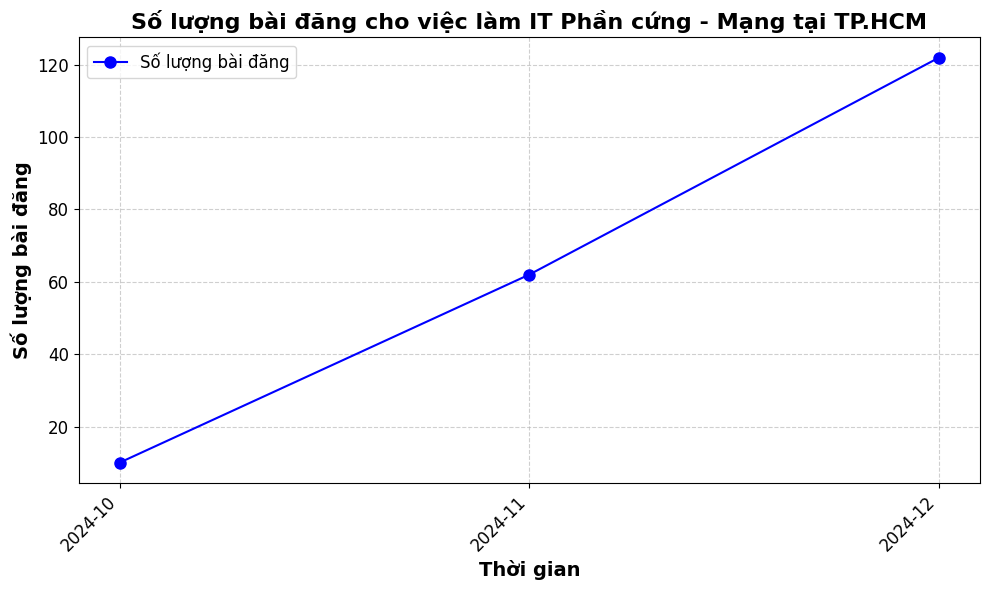

In [62]:
def plot_job_trend(job, city):
    job_data = aggregated_data[(aggregated_data['job'] == job) & (aggregated_data['city'] == city)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(job_data['month'].astype(str), job_data['number_of_job_posts'], marker='o', linestyle='-', color='b', markersize=8, label='Số lượng bài đăng')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('Thời gian', fontsize=14, fontweight='bold')
    plt.ylabel('Số lượng bài đăng', fontsize=14, fontweight='bold')
    plt.title(f'Số lượng bài đăng cho việc làm {job} tại {city}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_job_trend('IT Phần cứng - Mạng', 'TP.HCM')

In [63]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
aggregated_data['scaled_posts'] = scaler.fit_transform(aggregated_data['number_of_job_posts'].values.reshape(-1, 1))

# Mã hóa cột 'job' và 'city' với LabelEncoder
job_encoder = LabelEncoder()
city_encoder = LabelEncoder()
aggregated_data['job_encoded'] = job_encoder.fit_transform(aggregated_data['job'])
aggregated_data['city_encoded'] = city_encoder.fit_transform(aggregated_data['city'])

In [73]:
print(aggregated_data.head())


                     job        city    month  number_of_job_posts  \
0  Bán hàng - Kinh doanh  Bình Dương  2024-11                   35   
1  Bán hàng - Kinh doanh  Bình Dương  2024-12                  156   
2  Bán hàng - Kinh doanh   Bình Định  2024-11                   17   
3  Bán hàng - Kinh doanh   Bình Định  2024-12                  123   
4  Bán hàng - Kinh doanh    Bắc Ninh  2024-11                   10   

   scaled_posts  job_encoded  city_encoded  
0      0.054927            0             0  
1      0.250404            0             0  
2      0.025848            0             1  
3      0.197092            0             1  
4      0.014540            0             2  


In [65]:
def create_time_series(df, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(df) - time_steps):
        dataX.append(df[i : (i + time_steps), :])
        dataY.append(df[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

features = ['job_encoded', 'city_encoded', 'scaled_posts']
data_values = aggregated_data[features].values
time_steps = 5

X, y = create_time_series(data_values, time_steps)

In [66]:
# Chia dữ liệu thành tập train và test
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape dữ liệu để phù hợp với mô hình LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))

In [67]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(149, 5, 3) (149,)
(38, 5, 3) (38,)


In [68]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

c:\Data\VScode-Workspace\CapstoneProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 100)         │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,633 (482.94 KB)

 Trainable params: 123,633 (482.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0630 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0704 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0343 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0281 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0375 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0330 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 8/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0019
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - val_loss: 0.0205 - learning_ra

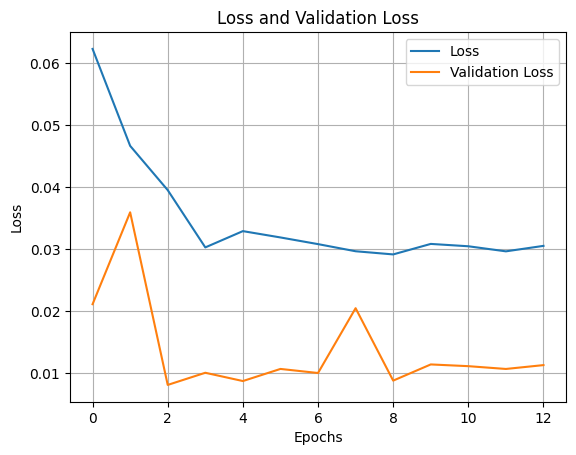

In [69]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [70]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_predict))

print(f"RMSE trên tập huấn luyện: {rmse_train}")
print(f"RMSE trên tập kiểm tra: {rmse_test}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
RMSE trên tập huấn luyện: 104.62506002121697
RMSE trên tập kiểm tra: 55.78317292363473


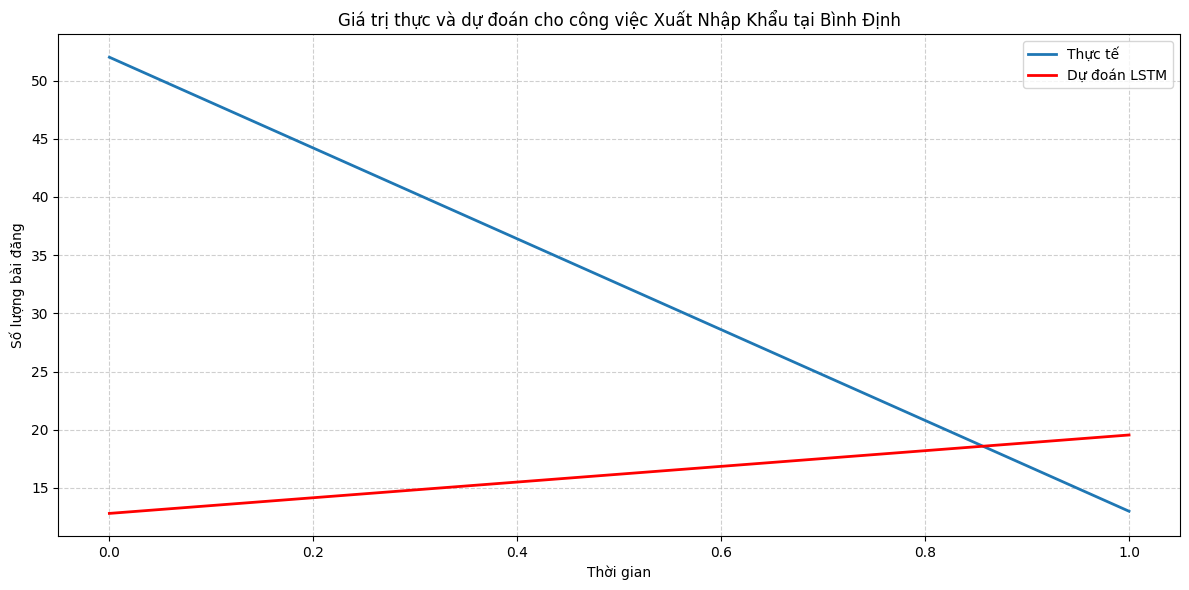

Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Bắc Ninh


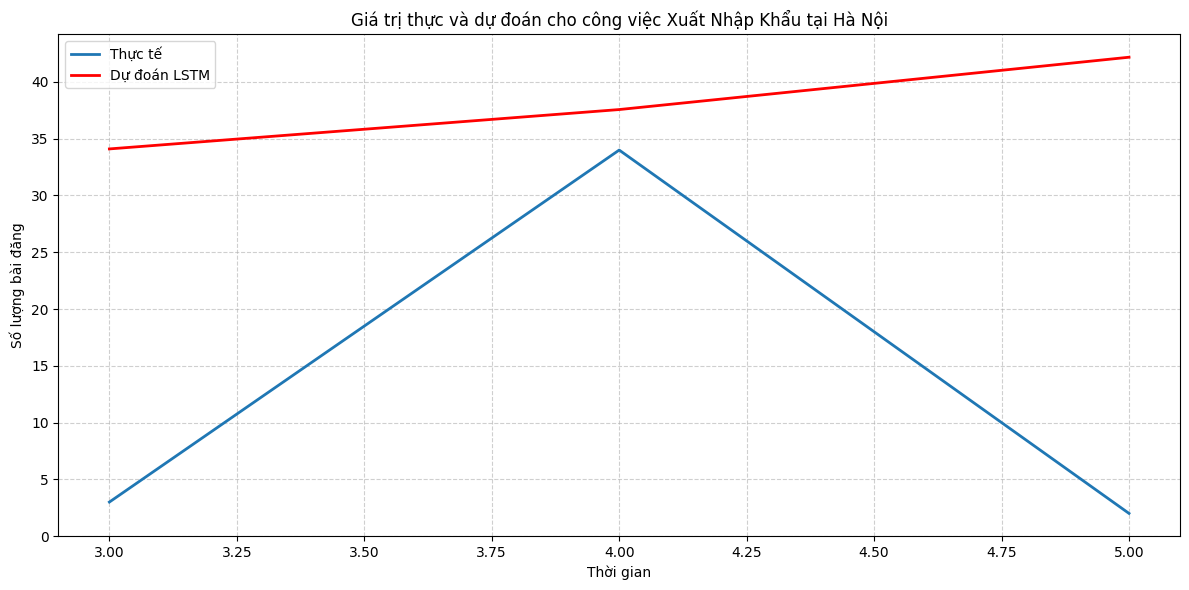

Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Hải Phòng


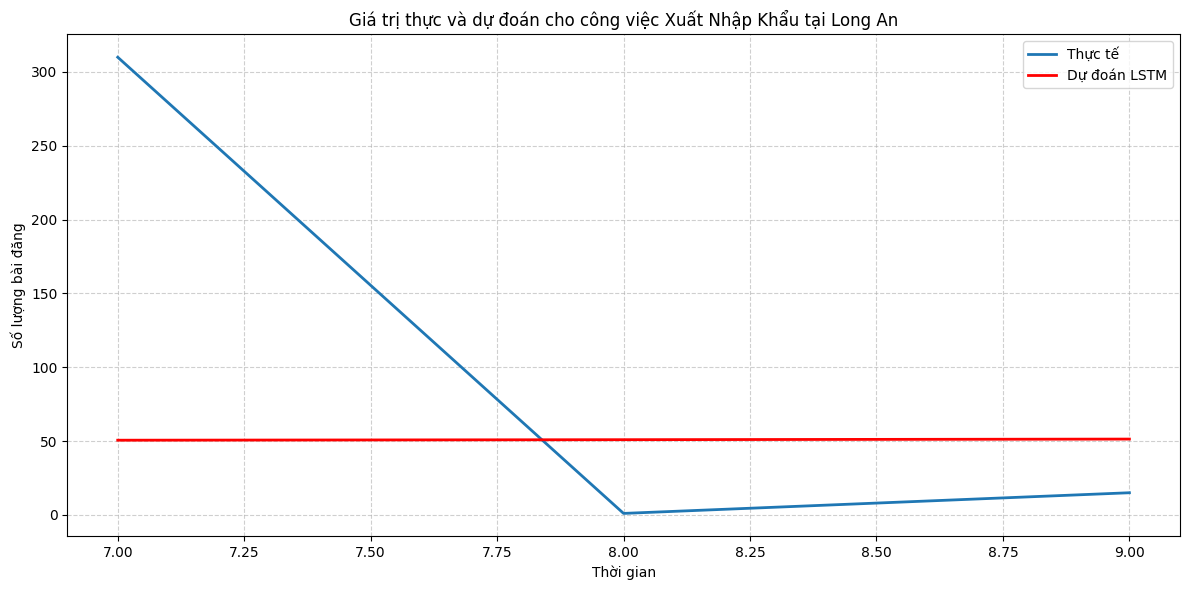

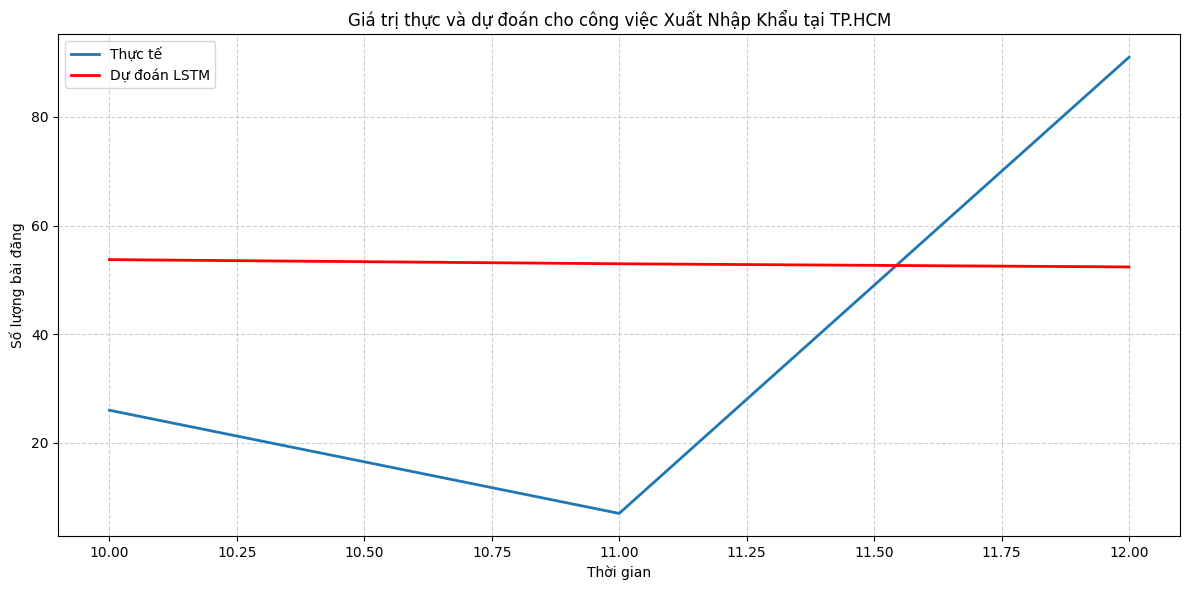

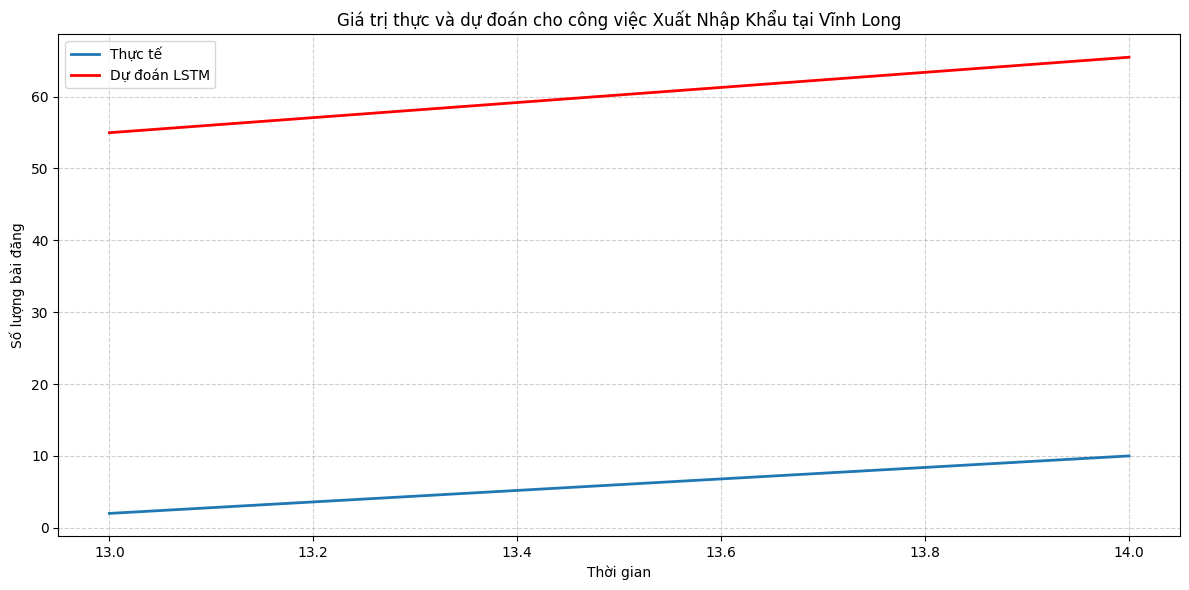

Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Đà Nẵng


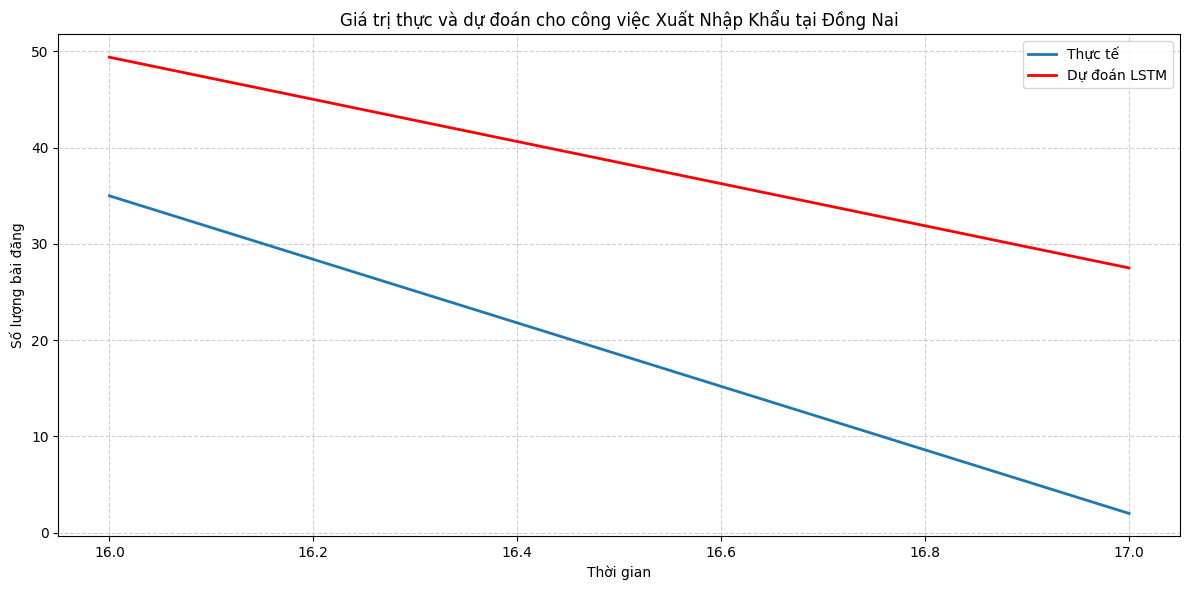

Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Bình Dương


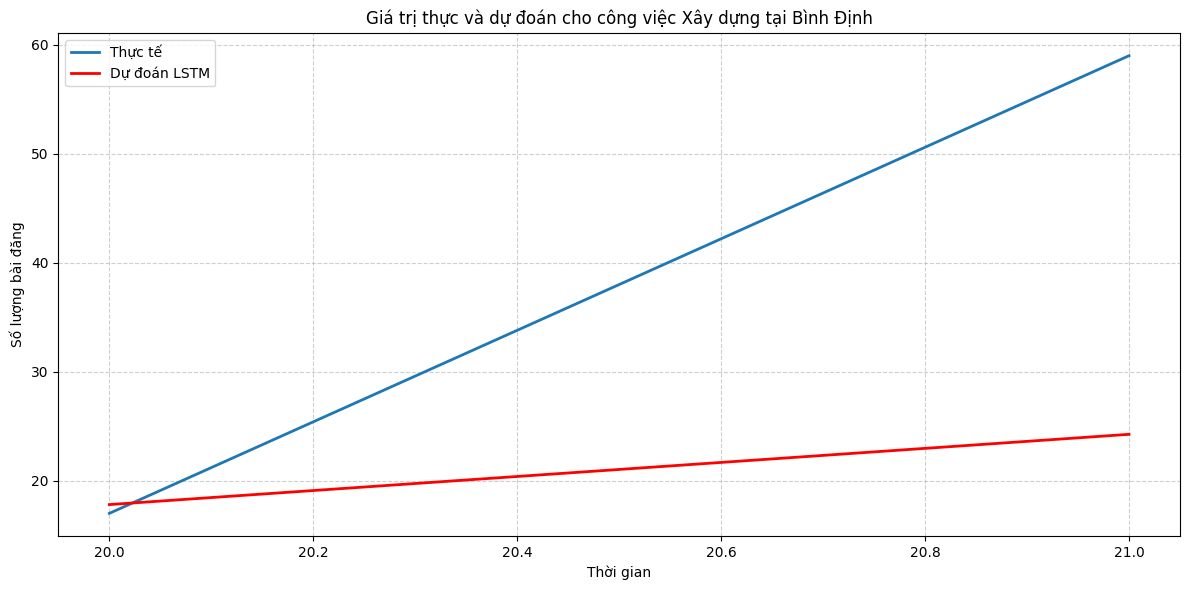

Không có dữ liệu cho công việc Xây dựng tại Bắc Ninh


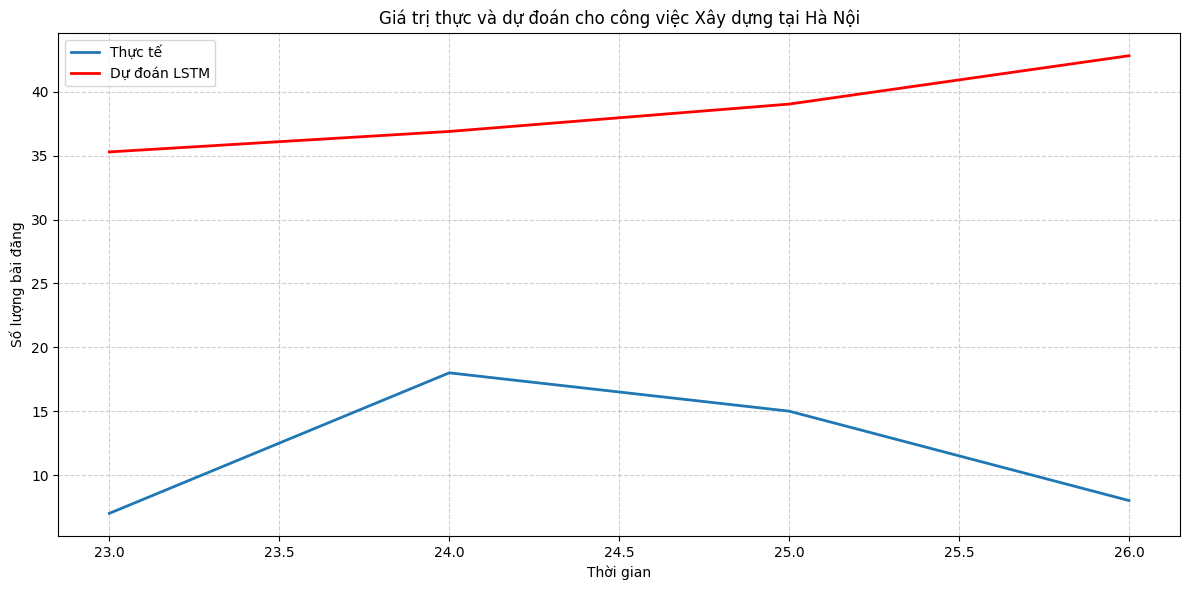

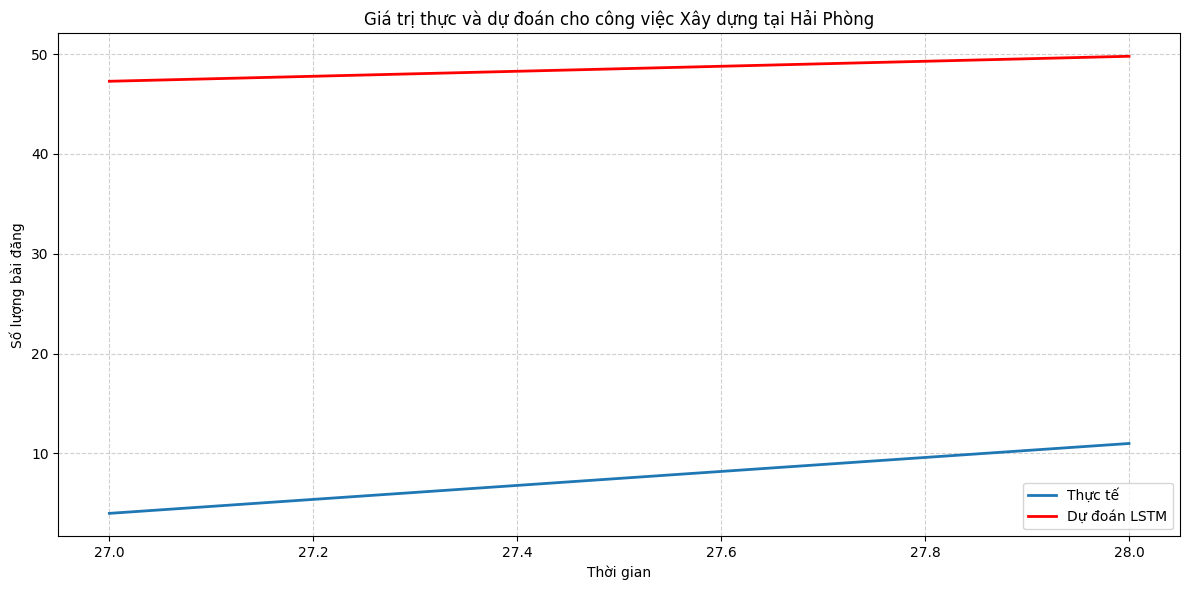

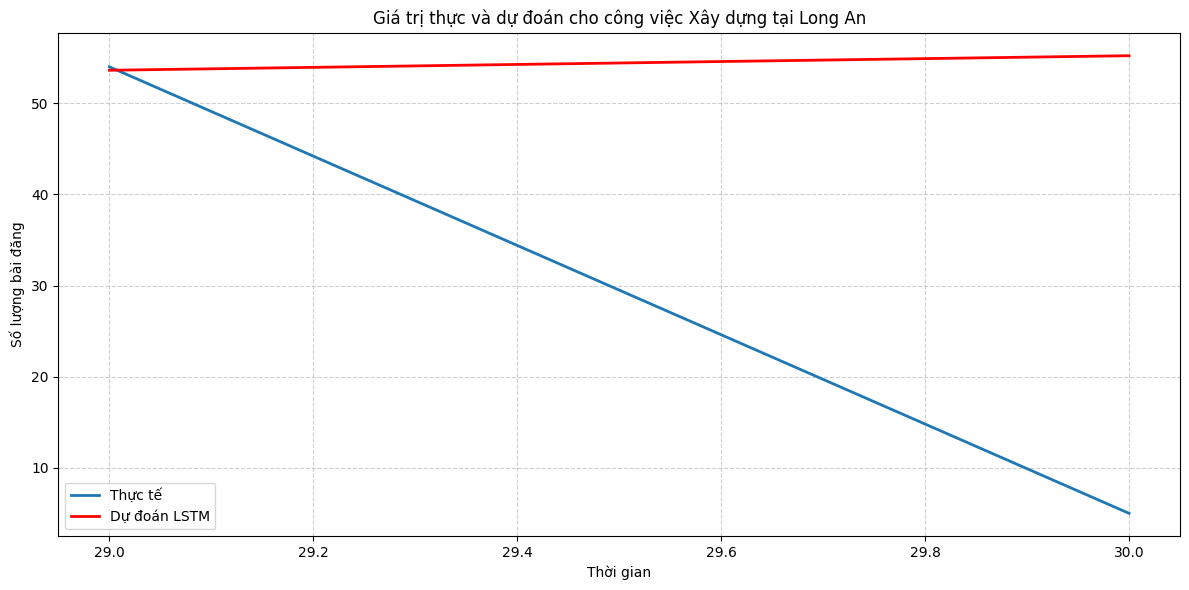

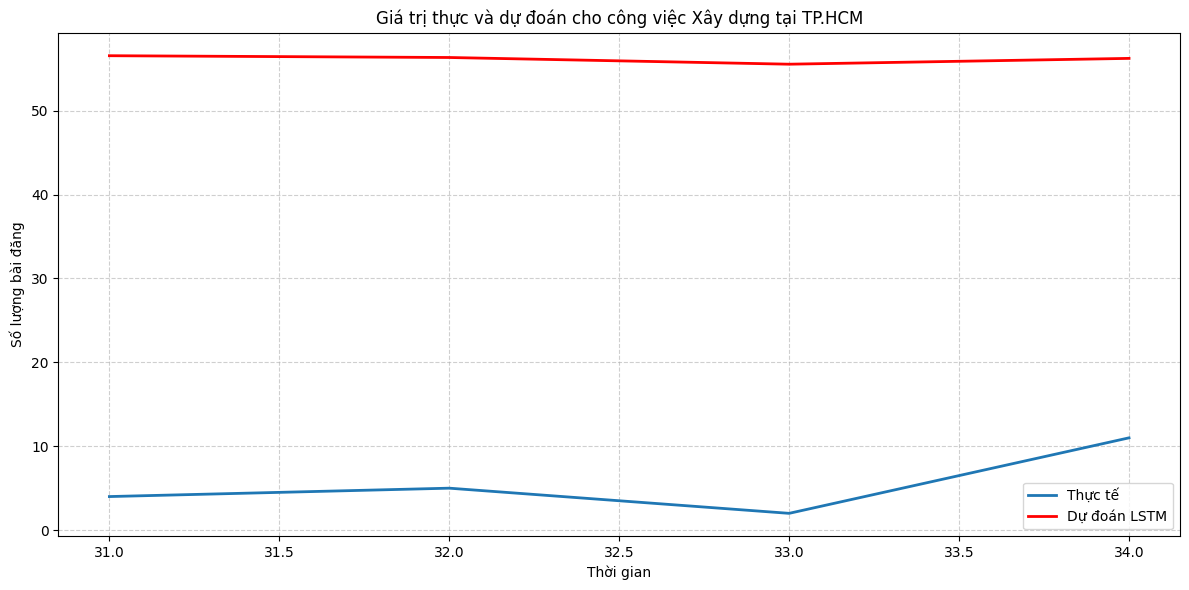

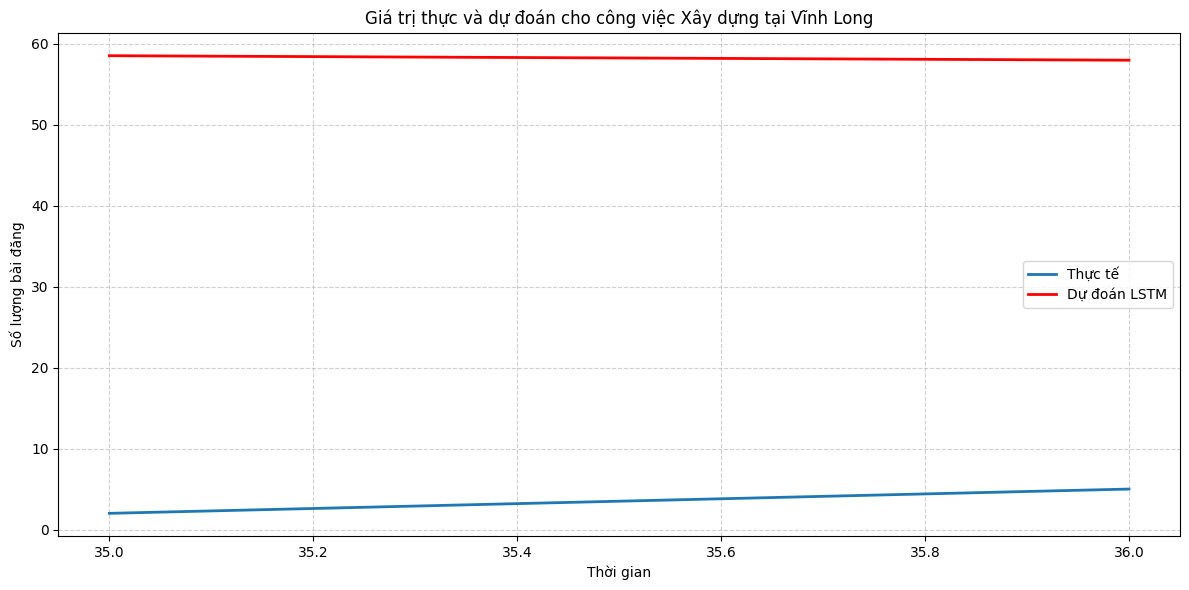

Không có dữ liệu cho công việc Xây dựng tại Đà Nẵng
Không có dữ liệu cho công việc Xây dựng tại Đồng Nai


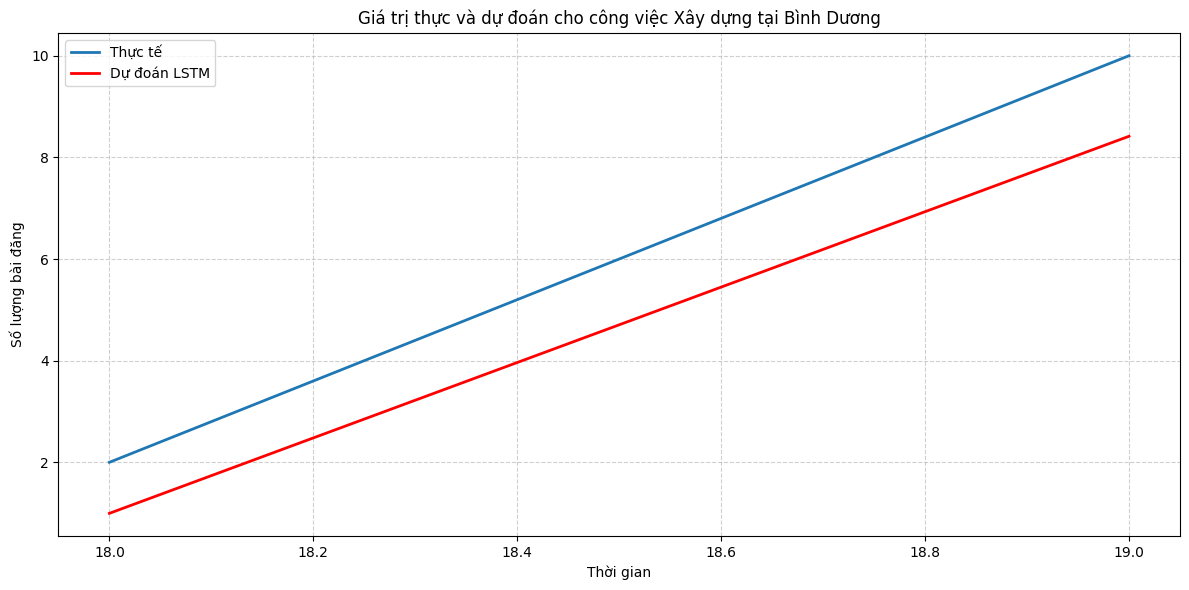

In [71]:
def plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder):
    # Lấy mã hóa job và city từ X_test
    job_encoded = X_test[:, 0, 0]
    city_encoded = X_test[:, 0, 1]
    
    # Tạo DataFrame cho dữ liệu kiểm tra
    test_data = pd.DataFrame({
        'job_encoded': job_encoded,
        'city_encoded': city_encoded,
        'actual': y_test_inv.flatten(),
        'predicted': test_predict.flatten()
    })
    
    # Chuyển mã hóa thành tên công việc và thành phố
    test_data['job'] = job_encoder.inverse_transform(test_data['job_encoded'].astype(int))
    test_data['city'] = city_encoder.inverse_transform(test_data['city_encoded'].astype(int))

    # Lấy danh sách công việc và thành phố duy nhất
    unique_jobs = test_data['job'].unique()
    unique_cities = test_data['city'].unique()
    
    for job in unique_jobs:
        for city in unique_cities:
            job_city_data = test_data[(test_data['job'] == job) & (test_data['city'] == city)]
            if len(job_city_data) > 1:
                plt.figure(figsize=(12, 6))
                plt.plot(job_city_data.index, job_city_data['actual'], label='Thực tế', linestyle='-', linewidth=2)
                plt.plot(job_city_data.index, job_city_data['predicted'], label='Dự đoán LSTM', color='red', linestyle='-', linewidth=2)
                plt.xlabel('Thời gian')
                plt.ylabel('Số lượng bài đăng')
                plt.title(f'Giá trị thực và dự đoán cho công việc {job} tại {city}')
                plt.legend()
                plt.grid(linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Không có dữ liệu cho công việc {job} tại {city}")
                
plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder)